# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size]) # I can do ds_val[i] to get the ith element of the subset
ds_train = Subset(ds_train, I[val_size:])

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 275kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.56MB/s]


#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [2]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad() # Zero gradients, otherwise they accumulate.
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step() # Update parameters.
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy()) # Detach from the calculation graph and move to CPU. (Import all the graph to the CPU or detach the graph and move to the CPU)
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [2]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])]) # Comprenhension list to create a list of layers. If I don't use the nn.ModuleList, the layers will not be registered in the model.
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 9: 100%|██████████| 430/430 [00:24<00:00, 17.47it/s] 


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.931     0.969     0.950       980
           1      0.953     0.980     0.966      1135
           2      0.921     0.888     0.904      1032
           3      0.891     0.888     0.889      1010
           4      0.910     0.921     0.915       982
           5      0.870     0.844     0.857       892
           6      0.928     0.936     0.932       958
           7      0.928     0.901     0.914      1028
           8      0.871     0.851     0.861       974
           9      0.873     0.896     0.885      1009

    accuracy                          0.909     10000
   macro avg      0.908     0.907     0.907     10000
weighted avg      0.909     0.909     0.909     10000



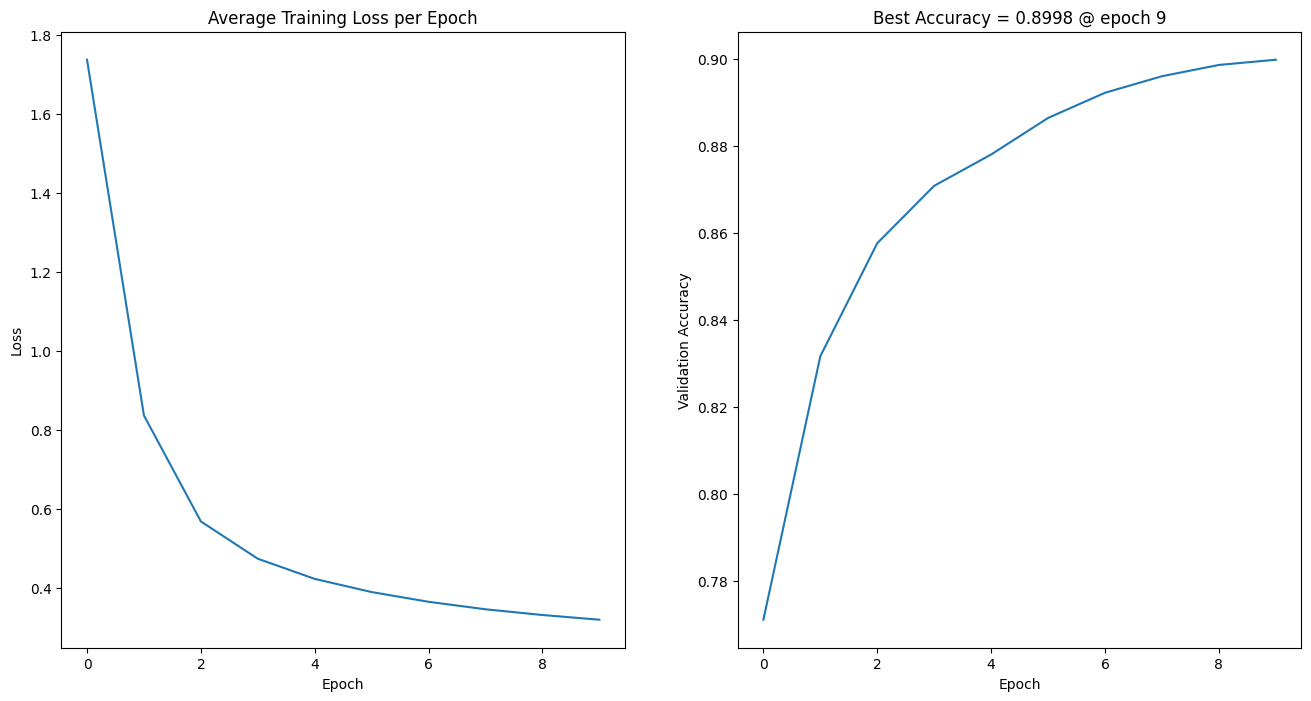

In [14]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
# See Tensorboard, Weights and Biases, or CometML for monitoring.
# tensor.grad is the gradient of the loss with respect to the input of the layer. It is used to compute the saliency maps.

In [2]:
class MyMLP(nn.Module):
    def __init__(self, opts):
        super().__init__()
        layers = []

        # input layer
        layers.append(nn.Linear(opts.input_size, opts.hidden_size))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(opts.hidden_layers):
            layers.append(nn.Linear(opts.hidden_size, opts.hidden_size))
            layers.append(nn.ReLU())

        # classification head
        layers.append(nn.Linear(opts.hidden_size, opts.num_classes))

        self.model = nn.Sequential(*layers) # *layers unpacks the list of layers into the Sequential constructor.
        # nn.Sequential() is a container for a sequence of layers. It is used to define the model.

    def forward(self, x):
        return self.model(x.flatten(1))

In [3]:
def evaluate_model(model, dl, opts):
    model = model.to(opts.device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient computation
        for i, (inputs, targets) in enumerate(dl):
            inputs, targets = inputs.to(opts.device), targets.to(opts.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return 100 * correct / total

def train_model(model, dl_train, dl_val, opts, optimizer):
    model = model.to(opts.device)
    losses = []
    accuracies = []

    for epoch in range(opts.epochs):
        print(f'Epoch {epoch + 1}')
        model.train()
        loss_values = []
        for i, (inputs, targets) in enumerate(dl_train):
            inputs, targets = inputs.to(opts.device), targets.to(opts.device)
            optimizer.zero_grad()
            outputs = model(inputs) # logits
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            loss_values.append(loss.item())

        losses.append(np.mean(loss_values))
        print(f'Loss: {losses[-1]}') # Print the last loss value
        print(f'Evaluating model on validation set...')
        accuracies.append(evaluate_model(model, dl_val, opts))
        print(f'Accuracy: {accuracies[-1]}') # Print the last accuracy value
    return losses, accuracies

In [5]:
from types import SimpleNamespace

opts = SimpleNamespace(
    dataset='MNIST',
    input_size = 28*28,
    hidden_layers = 2,
    hidden_size = 16,
    num_classes = 10,
    epochs = 50,
    lr = 0.0001,
    batch_size = 128,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    residual_layers = 2,
    residual_blocks = 1
)

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, opts.batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, opts.batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, opts.batch_size, shuffle=True, num_workers=4)

In [100]:
MLP_model = MyMLP(opts)
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=opts.lr)

MLP_losses, MLP_accuracies = train_model(MLP_model, dl_train, dl_val, opts, optimizer)

torch.save(MLP_model.state_dict(), 'MLP_model.pth') # save model

Epoch 1
Loss: 1.8415146974630134
Evaluating model on validation set...
Accuracy: 60.18
Epoch 2
Loss: 0.9183670128500738
Evaluating model on validation set...
Accuracy: 78.82
Epoch 3
Loss: 0.6424704630014508
Evaluating model on validation set...
Accuracy: 83.86
Epoch 4
Loss: 0.5312113310015478
Evaluating model on validation set...
Accuracy: 86.1
Epoch 5
Loss: 0.4629370093345642
Evaluating model on validation set...
Accuracy: 87.6
Epoch 6
Loss: 0.4151063898968142
Evaluating model on validation set...
Accuracy: 89.1
Epoch 7
Loss: 0.3790599426211313
Evaluating model on validation set...
Accuracy: 90.08
Epoch 8
Loss: 0.3509279865858167
Evaluating model on validation set...
Accuracy: 90.8
Epoch 9
Loss: 0.32852917916552965
Evaluating model on validation set...
Accuracy: 91.32
Epoch 10
Loss: 0.3100196150153182
Evaluating model on validation set...
Accuracy: 91.72
Epoch 11
Loss: 0.2946980089642281
Evaluating model on validation set...
Accuracy: 92.12
Epoch 12
Loss: 0.2819744587984196
Evaluating

In [4]:
def plot_losses_and_accuracies(losses, accuracies):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')

    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accuracies)} @ epoch {np.argmax(accuracies)}')

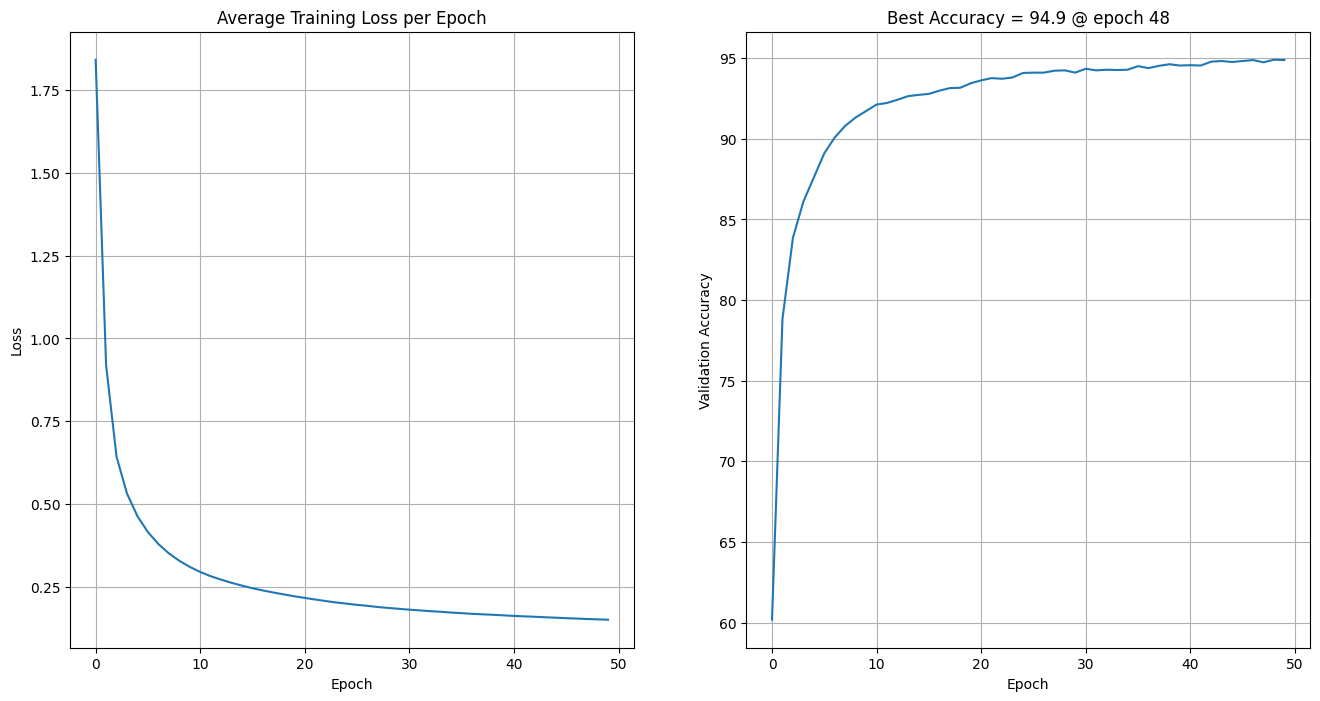

In [102]:
plot_losses_and_accuracies(MLP_losses, MLP_accuracies)

In [104]:
# load model from disk
model = MyMLP(opts)
model.load_state_dict(torch.load('MLP_model.pth', weights_only=True))

accuracy = evaluate_model(model, dl_test, opts)
print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 94.78


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, opts):
        super().__init__()
        layers = []

        for i in range(opts.residual_layers):
            layers.append(nn.Linear(opts.hidden_size, opts.hidden_size))
            layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden_layers(x.flatten(1)) + x.flatten(1)

In [6]:
class MyResidualMLP(nn.Module):
    def __init__(self, opts):
        super().__init__()
        layers = []

        # input layer
        layers.append(nn.Linear(opts.input_size, opts.hidden_size))
        layers.append(nn.ReLU())

        # residual blocks with skip connection
        for i in range(opts.residual_blocks):
            layers.append(ResidualBlock(opts))

        # classification head
        layers.append(nn.Linear(opts.hidden_size, opts.num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.flatten(1))

In [107]:
RES_model = MyResidualMLP(opts)
optimizer = torch.optim.Adam(RES_model.parameters(), lr=opts.lr)

RES_losses, RES_accuracies = train_model(RES_model, dl_train, dl_val, opts, optimizer)

torch.save(RES_model.state_dict(), 'RES_model.pth')

Epoch 1
Loss: 1.2772884806921316
Evaluating model on validation set...
Accuracy: 83.62
Epoch 2
Loss: 0.5481453522693279
Evaluating model on validation set...
Accuracy: 88.42
Epoch 3
Loss: 0.40940018978922865
Evaluating model on validation set...
Accuracy: 90.04
Epoch 4
Loss: 0.35336881851734114
Evaluating model on validation set...
Accuracy: 90.74
Epoch 5
Loss: 0.3222843459179235
Evaluating model on validation set...
Accuracy: 91.56
Epoch 6
Loss: 0.3019543953759726
Evaluating model on validation set...
Accuracy: 91.76
Epoch 7
Loss: 0.2867417231548664
Evaluating model on validation set...
Accuracy: 92.38
Epoch 8
Loss: 0.2745515324695166
Evaluating model on validation set...
Accuracy: 92.52
Epoch 9
Loss: 0.26438143294911054
Evaluating model on validation set...
Accuracy: 92.72
Epoch 10
Loss: 0.25596227405029676
Evaluating model on validation set...
Accuracy: 93.16
Epoch 11
Loss: 0.24813204121797583
Evaluating model on validation set...
Accuracy: 93.28
Epoch 12
Loss: 0.24135295954901118
E

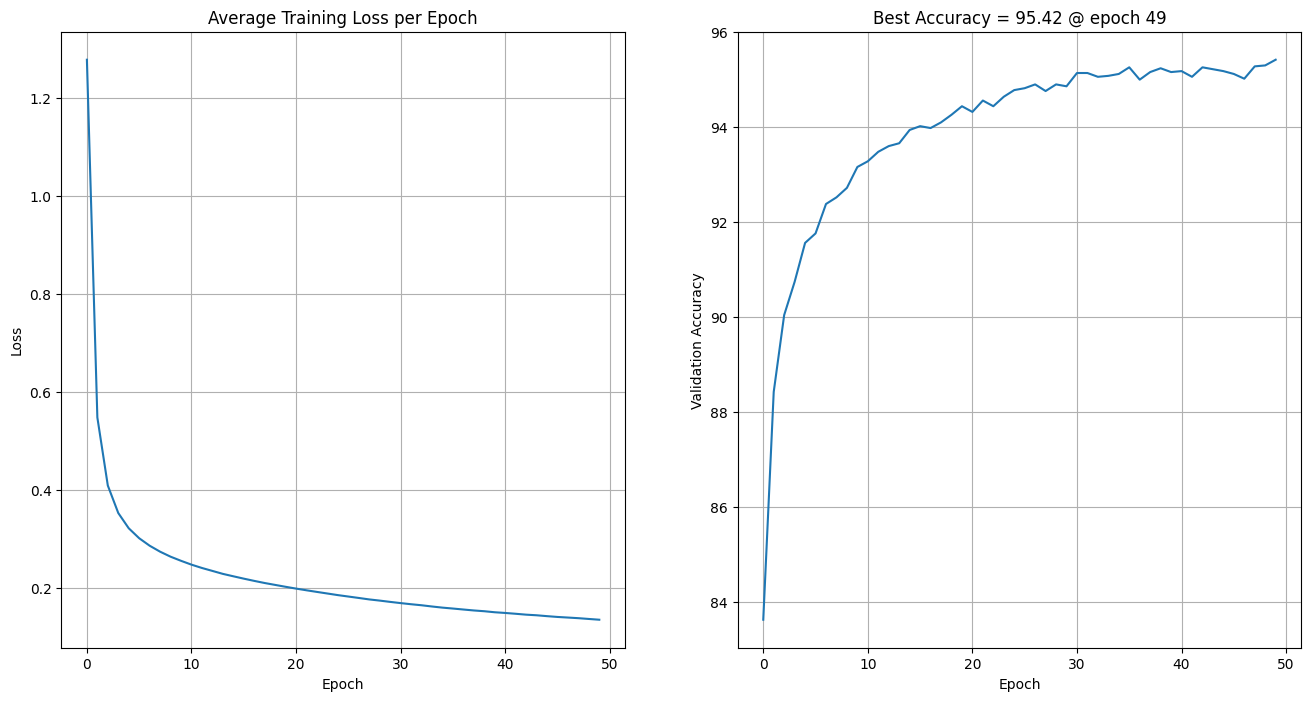

In [108]:
plot_losses_and_accuracies(RES_losses, RES_accuracies)

In [109]:
# load model from disk
model = MyResidualMLP(opts)
model.load_state_dict(torch.load('RES_model.pth', weights_only=True))

accuracy = evaluate_model(model, dl_test, opts)
print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 95.31


In [9]:
def compare_models(accuracies, labels, epoches):
    plt.grid()
    for i, accuracy in enumerate(accuracies):
        plt.plot(epoches, accuracy, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()

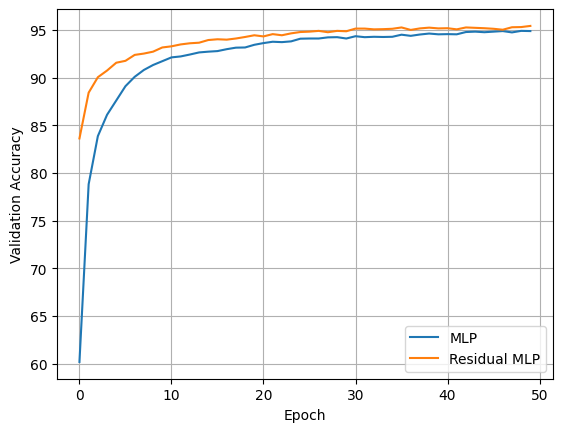

In [111]:
accuracies = [MLP_accuracies, RES_accuracies]
labels = ['MLP', 'Residual MLP']
epoches = range(opts.epochs)

compare_models(accuracies, labels, epoches)

In [10]:
def compare_depth(opts, num_iteration):
    accuracies = []
    labels = []

    for i in range(num_iteration):
        opts.residual_blocks = i
        opts.hidden_layers = 2 * i # Because each residual block is composed of 2 layers, in this way they have the same depth
        RES_model = MyResidualMLP(opts)
        optimizer = torch.optim.Adam(RES_model.parameters(), lr=opts.lr)
        _, accuracy = train_model(RES_model, dl_train, dl_val, opts, optimizer)
        accuracies.append(accuracy)
        labels.append(f'RES_model depth : {2 * i}')
        MLP_model = MyMLP(opts)
        optimizer = torch.optim.Adam(MLP_model.parameters(), lr=opts.lr)
        _, accuracy = train_model(MLP_model, dl_train, dl_val, opts, optimizer)
        accuracies.append(accuracy)
        labels.append(f'MLP_model depth : {2 * i}')
    return accuracies, labels

In [12]:
accuracies, labels = compare_depth(opts, num_iteration=2)

Epoch 1
Loss: 1.3392966921939407
Evaluating model on validation set...
Accuracy: 84.04
Epoch 2
Loss: 0.6005006228768548
Evaluating model on validation set...
Accuracy: 87.78
Epoch 3
Loss: 0.4426591011673905
Evaluating model on validation set...
Accuracy: 89.3
Epoch 4
Loss: 0.38112561002720236
Evaluating model on validation set...
Accuracy: 90.02
Epoch 5
Loss: 0.3478928207311519
Evaluating model on validation set...
Accuracy: 90.54
Epoch 6
Loss: 0.32647157294112583
Evaluating model on validation set...
Accuracy: 91.02
Epoch 7
Loss: 0.31130343796901927
Evaluating model on validation set...
Accuracy: 91.38
Epoch 8
Loss: 0.2995206828727279
Evaluating model on validation set...
Accuracy: 91.62
Epoch 9
Loss: 0.2903171282868053
Evaluating model on validation set...
Accuracy: 91.78
Epoch 10
Loss: 0.28228117338446684
Evaluating model on validation set...
Accuracy: 92.0
Epoch 11
Loss: 0.2756521113736685
Evaluating model on validation set...
Accuracy: 92.16
Epoch 12
Loss: 0.2696163274521051
Evalu

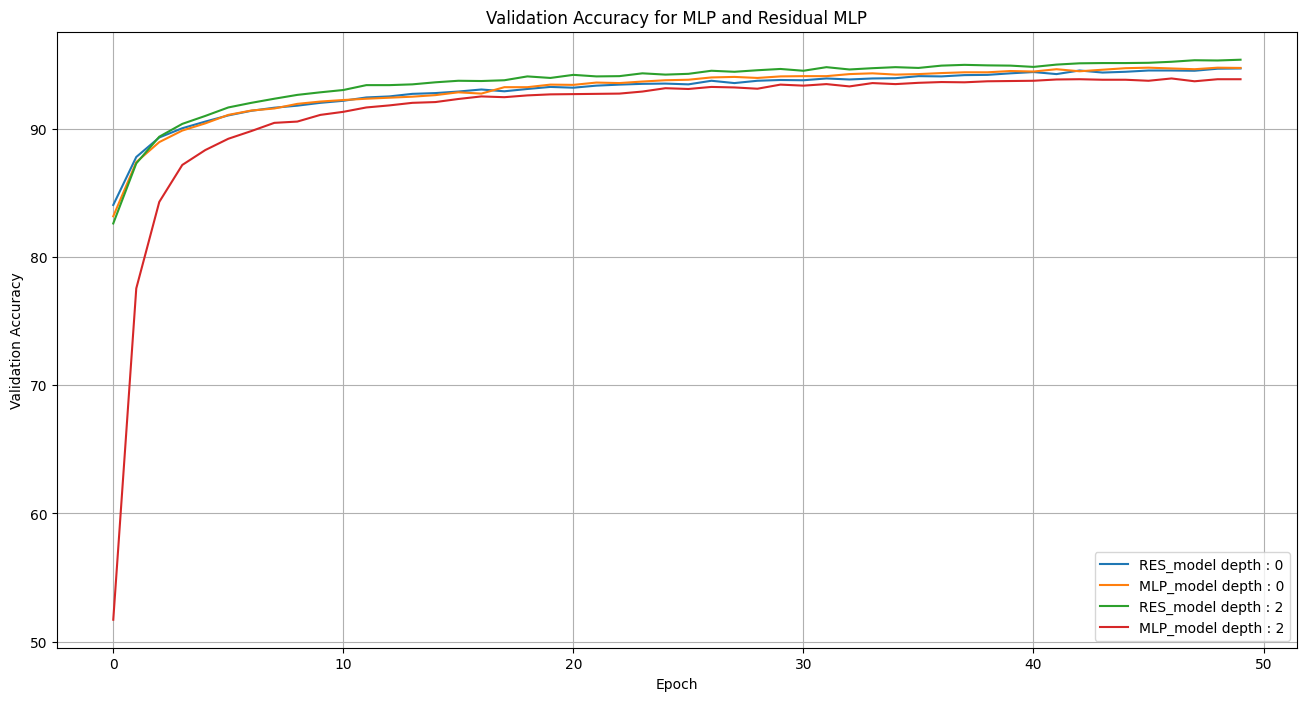

In [17]:
# print accuracies and labels in a plot
plt.figure(figsize=(16, 8))
plt.grid()
for i, accuracy in enumerate(accuracies):
    plt.plot(accuracy, label=labels[i])
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for MLP and Residual MLP')
plt.legend()
plt.show()


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, block_dimension, skip_connection):
        super().__init__()
        layers = []
        input_channels = in_channels # to keep track of the input channels for the skip connection

        for i in range(block_dimension):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)) # padding=1 to keep the spatial dimensions
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            in_channels = out_channels

        layers.append(nn.MaxPool2d(stride))

        self.block = nn.Sequential(*layers)

        self.skip_connection = skip_connection
        if self.skip_connection:
            self.skip = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=stride)


    def forward(self, x):
        if self.skip_connection:
            return self.block(x) + self.skip(x)
        else:
            return self.block(x)

In [8]:
class MyCNN(nn.Module):
    def __init__(self, opts):
        super().__init__()
        layers = []

        # first block
        layers.append(CNNBlock(3, opts.output_channels, opts.kernel_size, opts.stride , opts.block_dimension, opts.skip_connection))

        output_channels = opts.output_channels
        # second and other blocks
        for i in range(opts.blocks_number):
            layers.append(CNNBlock(output_channels, output_channels * 2, opts.kernel_size, opts.stride, opts.block_dimension, opts.skip_connection))
            output_channels *= 2

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            output = reduce(lambda f, g: lambda x: g(f(x)), layers, lambda x: x)(dummy_input)
            output.flatten(1)
            opts.input_size = output.numel() # numel() returns the number of elements in the tensor, used to set automatically the input size of the MLP model

        # classification head
        layers.append(MyMLP(opts))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
from torchvision.datasets import CIFAR10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar

ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

100%|██████████| 170M/170M [00:06<00:00, 24.4MB/s] 


In [15]:
from types import SimpleNamespace

opts = SimpleNamespace(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    blocks_number = 3, # number of CNNblocks
    output_channels = 32,
    kernel_size = 3,
    stride = 2, # maxpooling stride
    block_dimension = 2, # number of layers in each CNNblock
    skip_connection = False, # skip connection in CNNblock
    hidden_layers = 0, # depth of MLP
    input_size = 1, # it will be updated in the CNN model
    num_classes = 10,
    hidden_size = 256,
    epochs = 50,
    lr = 0.0001,
    batch_size = 64
)

dl_train = torch.utils.data.DataLoader(ds_train, opts.batch_size, shuffle=True, num_workers=4)
dl_val = torch.utils.data.DataLoader(ds_val, opts.batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, opts.batch_size, shuffle=True, num_workers=4)

In [18]:
# print the structure of the model
import torchsummary

CNNmodel = MyCNN(opts)
CNNmodel.to(opts.device)
torchsummary.summary(CNNmodel, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
          CNNBlock-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [19]:
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=opts.lr)
CNNlosses, CNNaccuracies = train_model(CNNmodel, dl_train, dl_val, opts, optimizer)
torch.save(CNNmodel.state_dict(), 'CNN_model.pth')

Epoch 1
Loss: 1.248253512958234
Evaluating model on validation set...
Accuracy: 62.72
Epoch 2
Loss: 0.8165695939467035
Evaluating model on validation set...
Accuracy: 70.98
Epoch 3
Loss: 0.6107900936410509
Evaluating model on validation set...
Accuracy: 73.64
Epoch 4
Loss: 0.4485083421141925
Evaluating model on validation set...
Accuracy: 74.84
Epoch 5
Loss: 0.31220729231030087
Evaluating model on validation set...
Accuracy: 72.56
Epoch 6
Loss: 0.2048243557642722
Evaluating model on validation set...
Accuracy: 73.42
Epoch 7
Loss: 0.13189866902063263
Evaluating model on validation set...
Accuracy: 74.12
Epoch 8
Loss: 0.10915288550048982
Evaluating model on validation set...
Accuracy: 73.16
Epoch 9
Loss: 0.08433171665952117
Evaluating model on validation set...
Accuracy: 74.98
Epoch 10
Loss: 0.07561384665843268
Evaluating model on validation set...
Accuracy: 73.08
Epoch 11
Loss: 0.06902734752921705
Evaluating model on validation set...
Accuracy: 74.0
Epoch 12
Loss: 0.07113392845547589
Ev

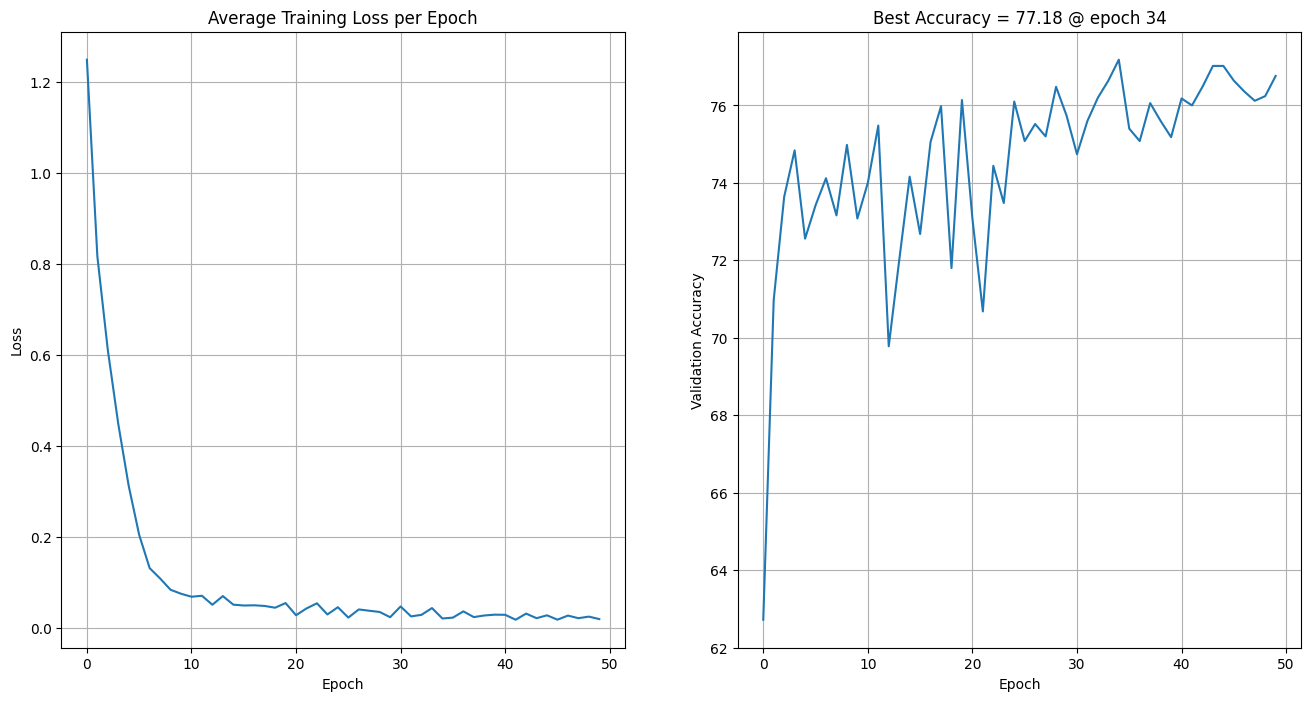

In [20]:
plot_losses_and_accuracies(CNNlosses, CNNaccuracies)

In [21]:
'''model = MyCNN(opts)
model.load_state_dict(torch.load('C:CNN_model.pth'))
accuracy = evaluate_model(model, dl_test, opts)'''

print(f'Accuracy on test set with CNN model: {evaluate_model(CNNmodel, dl_test, opts)}')

Accuracy on test set with CNN model: 77.28


In [27]:
# CNN model with skip connections
opts.skip_connection = True

SkipCNNmodel = MyCNN(opts)

In [28]:
optimizer = torch.optim.Adam(SkipCNNmodel.parameters(), lr=opts.lr)
SkipCNNlosses, SkipCNNaccuracies = train_model(SkipCNNmodel, dl_train, dl_val, opts, optimizer)
torch.save(SkipCNNmodel.state_dict(), 'SkipCNN_model.pth')

Epoch 1
Loss: 1.2639621186324141
Evaluating model on validation set...
Accuracy: 62.46
Epoch 2
Loss: 0.8337952111932364
Evaluating model on validation set...
Accuracy: 67.72
Epoch 3
Loss: 0.6139009636826813
Evaluating model on validation set...
Accuracy: 72.78
Epoch 4
Loss: 0.4374095989306542
Evaluating model on validation set...
Accuracy: 72.62
Epoch 5
Loss: 0.28389656749045983
Evaluating model on validation set...
Accuracy: 72.96
Epoch 6
Loss: 0.16678656058237804
Evaluating model on validation set...
Accuracy: 72.16
Epoch 7
Loss: 0.10168607866481497
Evaluating model on validation set...
Accuracy: 71.96
Epoch 8
Loss: 0.08256204948966941
Evaluating model on validation set...
Accuracy: 73.02
Epoch 9
Loss: 0.07923470254966312
Evaluating model on validation set...
Accuracy: 73.44
Epoch 10
Loss: 0.053607308631895154
Evaluating model on validation set...
Accuracy: 73.86
Epoch 11
Loss: 0.06774036138350228
Evaluating model on validation set...
Accuracy: 73.3
Epoch 12
Loss: 0.0497957430168092


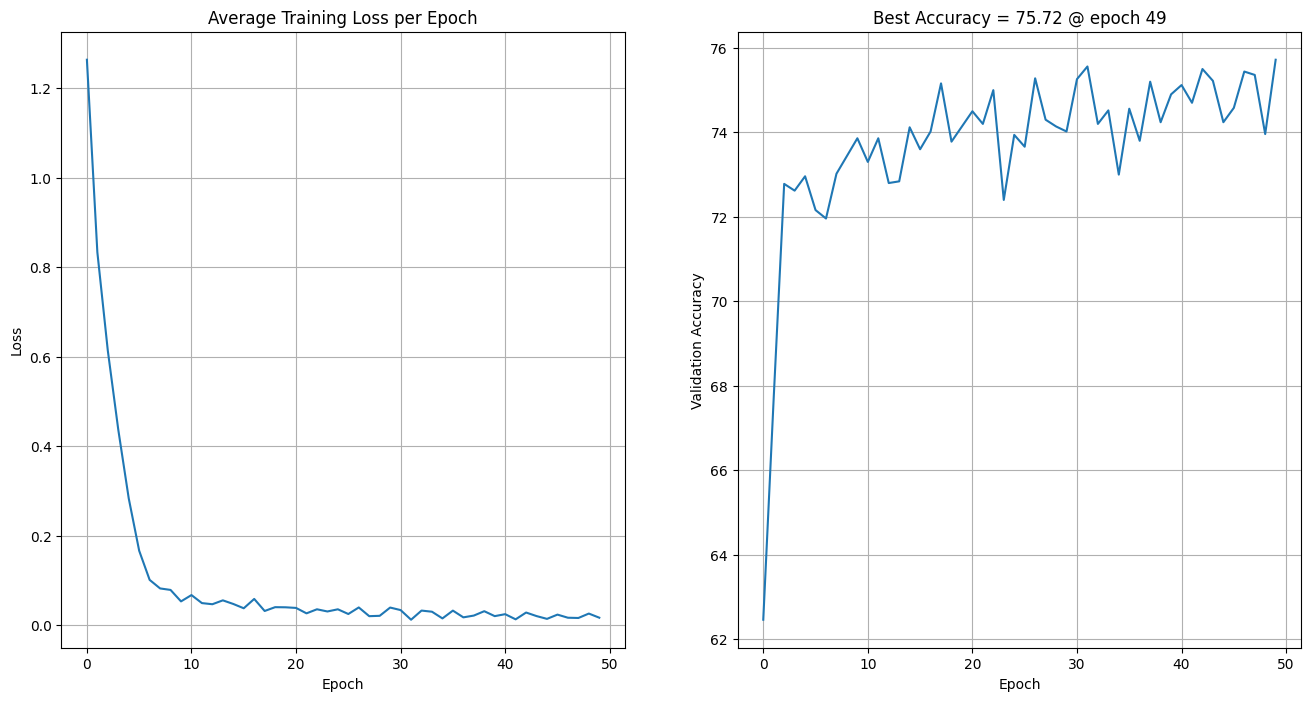

In [29]:
plot_losses_and_accuracies(SkipCNNlosses, SkipCNNaccuracies)

In [30]:
'''model = MyCNN(opts)
model.load_state_dict(torch.load('SkipCNN_model.pth'))
accuracy = evaluate_model(model, dl_test, opts)'''

print(f'Accuracy on test set with SkipCNN model: {evaluate_model(SkipCNNmodel, dl_test, opts)}')

Accuracy on test set with SkipCNN model: 75.94


In [52]:
import copy

model1 = copy.deepcopy(SkipCNNmodel)
model2 = copy.deepcopy(SkipCNNmodel)
model3 = copy.deepcopy(SkipCNNmodel)
model4 = copy.deepcopy(SkipCNNmodel)

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [32]:
# CNNmodel.model.children() returns an iterator over the modules in the model. I convert it to a list to use the slicing notation. [:-1] removes the last element of the list (the classification head)

model1.model = nn.Sequential(*list(model1.model.children())[:-1])
torchsummary.summary(model1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]             128
          CNNBlock-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

In [33]:
from torchvision.datasets import CIFAR100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds_train = CIFAR100(root='./data', train=True, download=True, transform=transform)
ds_test = CIFAR100(root='./data', train=False, download=True, transform=transform)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

100%|██████████| 169M/169M [00:06<00:00, 24.5MB/s] 


In [34]:
dl_train = torch.utils.data.DataLoader(ds_train, opts.batch_size, shuffle=True, num_workers=4)
dl_val = torch.utils.data.DataLoader(ds_val, opts.batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, opts.batch_size, shuffle=True, num_workers=4)

In [35]:
def extract_features(model, dl, device):
    model = model.to(device)
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1) # flatten the output tensor to use it as input for the SVM
            features.append(outputs)
            labels.append(targets)
        print(f"feature shape: {outputs[0].shape}")

    return torch.cat(features), torch.cat(labels)

In [36]:
# Extract the features from the CNN model before the classification head
features_train, labels_train = extract_features(model1, dl_train, opts.device)

feature shape: torch.Size([1024])


In [38]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# feature standardization
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train.cpu().numpy())

# Reduce the dimensionality to a lower number of components
pca = PCA(n_components=100)
features_train_pca = pca.fit_transform(features_train_scaled)

clf = LinearSVC()  # Linear SVM
print("start fitting")
clf.fit(features_train_pca, labels_train.cpu().numpy())
print("end fitting")

print("extracting features")
features_test, labels_test = extract_features(model1, dl_test, opts.device)
features_test_scaled = scaler.transform(features_test.cpu().numpy())
features_test_pca = pca.transform(features_test_scaled)
print("end extracting features")

accuracy = clf.score(features_test_pca, labels_test.cpu().numpy())
print(f'Accuracy on test set with SVM: {accuracy}')


start fitting
end fitting
extracting features
feature shape: torch.Size([1024])
end extracting features
Accuracy on test set with SVM: 0.3094


In [39]:
# remove classification head
model2.model = nn.Sequential(*list(model2.model.children())[:-1])

# add a new classification head
opts.num_classes = 100
model2.model.add_module('classifier', MyMLP(opts))

# fine-tune all the model with SGD optimizer
optimizer = torch.optim.SGD(model2.parameters(), lr=opts.lr, momentum = 0.9)
SkipCNNlosses, SkipCNNaccuracies = train_model(model2, dl_train, dl_val, opts, optimizer)
torch.save(model2.state_dict(), 'SkipCNN_model_finetuned.pth')

Epoch 1
Loss: 4.579380961981687
Evaluating model on validation set...
Accuracy: 2.88
Epoch 2
Loss: 4.463125791062009
Evaluating model on validation set...
Accuracy: 5.94
Epoch 3
Loss: 4.29868975484913
Evaluating model on validation set...
Accuracy: 9.18
Epoch 4
Loss: 4.086421219801361
Evaluating model on validation set...
Accuracy: 12.72
Epoch 5
Loss: 3.852897545492107
Evaluating model on validation set...
Accuracy: 15.86
Epoch 6
Loss: 3.611065358939496
Evaluating model on validation set...
Accuracy: 19.7
Epoch 7
Loss: 3.384266695177013
Evaluating model on validation set...
Accuracy: 22.24
Epoch 8
Loss: 3.1922830658202823
Evaluating model on validation set...
Accuracy: 24.64
Epoch 9
Loss: 3.0336624763228675
Evaluating model on validation set...
Accuracy: 26.76
Epoch 10
Loss: 2.9045103869654914
Evaluating model on validation set...
Accuracy: 28.74
Epoch 11
Loss: 2.788043003867973
Evaluating model on validation set...
Accuracy: 29.8
Epoch 12
Loss: 2.6939329437234183
Evaluating model on v

In [50]:
torchsummary.summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]             128
          CNNBlock-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

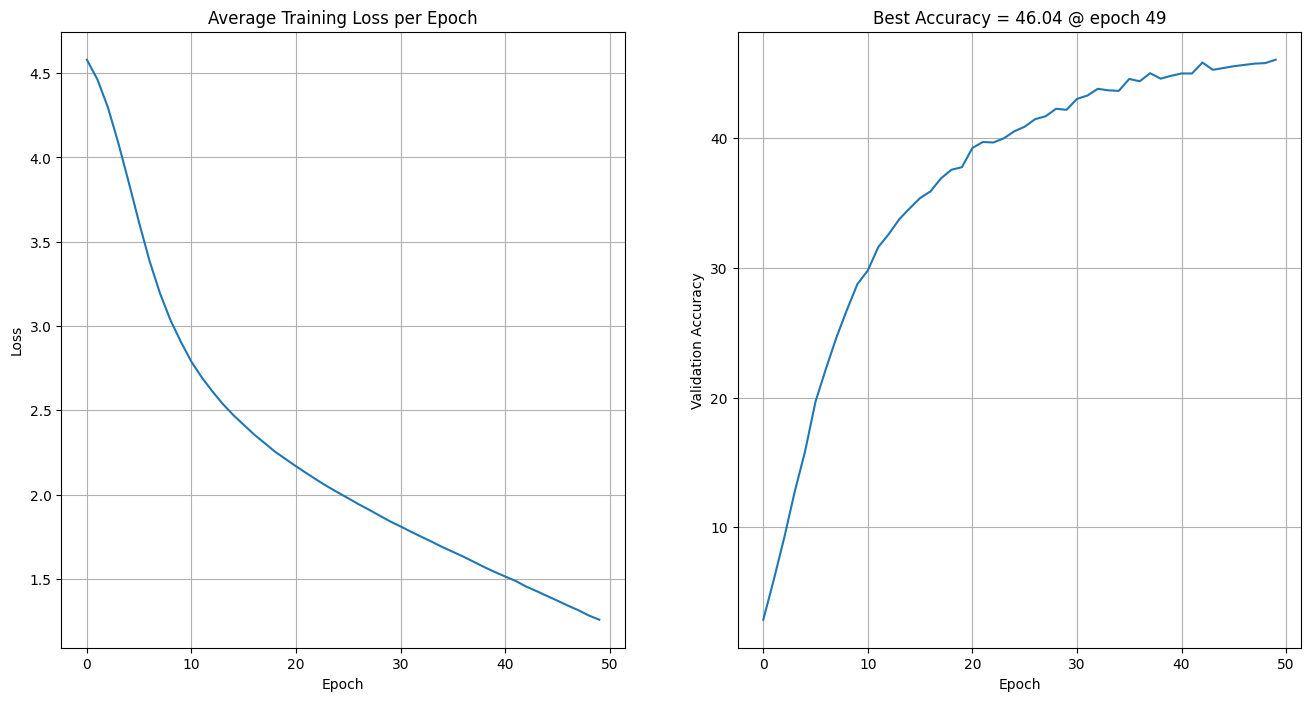

In [40]:
plot_losses_and_accuracies(SkipCNNlosses, SkipCNNaccuracies)

In [41]:
print(f'Accuracy on test set: {evaluate_model(model2, dl_test, opts)}')

Accuracy on test set: 45.89


In [44]:
# remove classification head
model3.model = nn.Sequential(*list(model3.model.children())[:-1])

# freeze the convolutional layer
for param in model3.parameters():
    param.requires_grad = False # requires_grad is a flag that allows to freeze the parameters of the model

# add a new classification head
opts.num_classes = 100
model3.model.add_module('classifier', MyMLP(opts))

torchsummary.summary(model3.to(opts.device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]             128
          CNNBlock-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

In [45]:
optimizer = torch.optim.SGD(model3.parameters(), lr=opts.lr, momentum = 0.9)
SkipCNNlosses, SkipCNNaccuracies = train_model(model3, dl_train, dl_val, opts, optimizer)
torch.save(model3.state_dict(), 'SkipCNN_model_finetuned_unfreeze_onlyhead.pth')

Epoch 1
Loss: 4.6029536757956855
Evaluating model on validation set...
Accuracy: 2.08
Epoch 2
Loss: 4.534105918624184
Evaluating model on validation set...
Accuracy: 3.86
Epoch 3
Loss: 4.461288345131007
Evaluating model on validation set...
Accuracy: 5.52
Epoch 4
Loss: 4.374478270384398
Evaluating model on validation set...
Accuracy: 7.36
Epoch 5
Loss: 4.2718546431172975
Evaluating model on validation set...
Accuracy: 9.66
Epoch 6
Loss: 4.15471041304144
Evaluating model on validation set...
Accuracy: 12.18
Epoch 7
Loss: 4.029867462813854
Evaluating model on validation set...
Accuracy: 14.36
Epoch 8
Loss: 3.902524771676822
Evaluating model on validation set...
Accuracy: 16.52
Epoch 9
Loss: 3.7787274691191586
Evaluating model on validation set...
Accuracy: 18.02
Epoch 10
Loss: 3.662763600322333
Evaluating model on validation set...
Accuracy: 19.28
Epoch 11
Loss: 3.5539154600013387
Evaluating model on validation set...
Accuracy: 20.94
Epoch 12
Loss: 3.458151238208467
Evaluating model on v

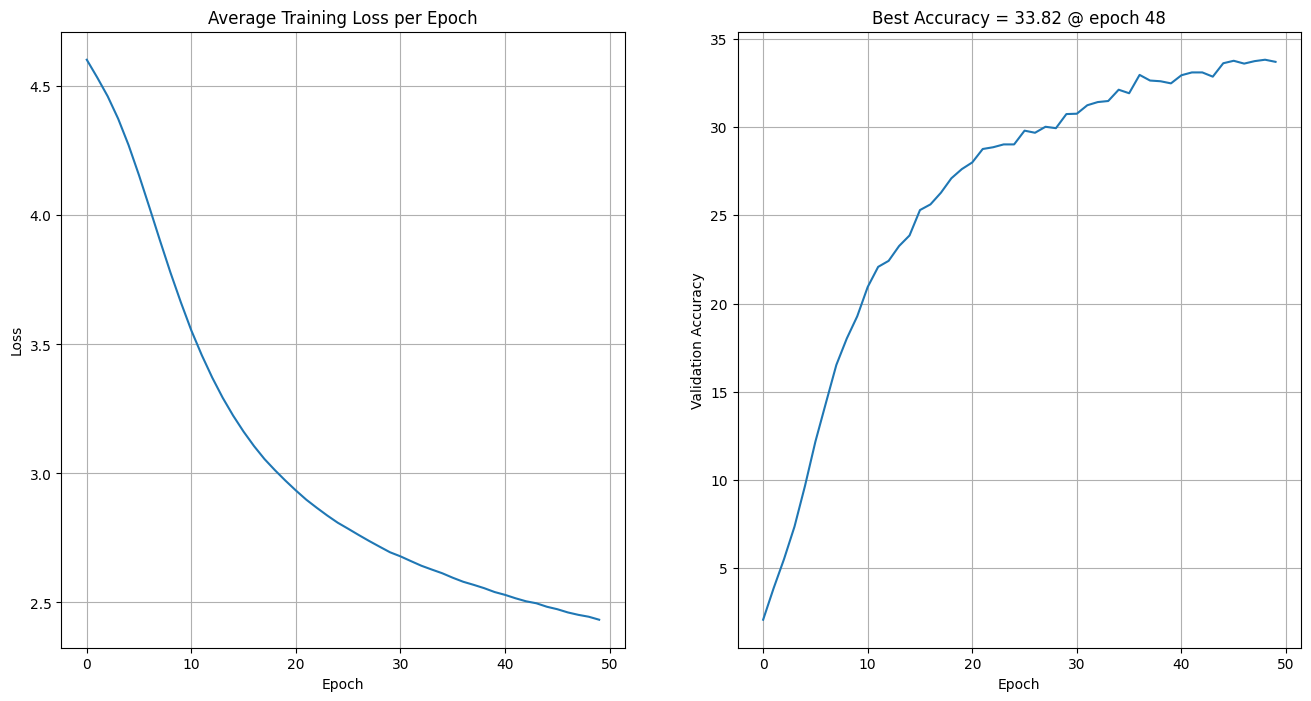

In [46]:
plot_losses_and_accuracies(SkipCNNlosses, SkipCNNaccuracies)

In [47]:
print(f'Accuracy on test set: {evaluate_model(model3, dl_test, opts)}')

Accuracy on test set: 34.69


In [48]:
# another 50 epochs
train_model(model3, dl_train, dl_val, opts, optimizer)

Epoch 1
Loss: 2.426555335183035
Evaluating model on validation set...
Accuracy: 34.14
Epoch 2
Loss: 2.415010231801055
Evaluating model on validation set...
Accuracy: 33.88
Epoch 3
Loss: 2.406062172895128
Evaluating model on validation set...
Accuracy: 34.28
Epoch 4
Loss: 2.3983288747681812
Evaluating model on validation set...
Accuracy: 34.26
Epoch 5
Loss: 2.390564371577718
Evaluating model on validation set...
Accuracy: 34.42
Epoch 6
Loss: 2.3788788894360717
Evaluating model on validation set...
Accuracy: 34.58
Epoch 7
Loss: 2.3741501542654904
Evaluating model on validation set...
Accuracy: 34.34
Epoch 8
Loss: 2.364985940639268
Evaluating model on validation set...
Accuracy: 34.92
Epoch 9
Loss: 2.3556972843679516
Evaluating model on validation set...
Accuracy: 34.72
Epoch 10
Loss: 2.3499899029054423
Evaluating model on validation set...
Accuracy: 34.7
Epoch 11
Loss: 2.340208799493584
Evaluating model on validation set...
Accuracy: 34.78
Epoch 12
Loss: 2.3337955200536684
Evaluating mod

([2.426555335183035,
  2.415010231801055,
  2.406062172895128,
  2.3983288747681812,
  2.390564371577718,
  2.3788788894360717,
  2.3741501542654904,
  2.364985940639268,
  2.3556972843679516,
  2.3499899029054423,
  2.340208799493584,
  2.3337955200536684,
  2.3264154741032557,
  2.3168149368668143,
  2.3100180238146675,
  2.303548600863327,
  2.2979982051659715,
  2.290348096666011,
  2.2824072602458974,
  2.275857033885338,
  2.271690363403071,
  2.263782662593506,
  2.256895274431868,
  2.250987065278671,
  2.2427183663980528,
  2.2380713786591184,
  2.232997474853288,
  2.2241327410394494,
  2.2207490624013273,
  2.214471719312397,
  2.2075875492935833,
  2.2023106776177883,
  2.198641413314776,
  2.1876585962758823,
  2.1841805746609513,
  2.180278927087784,
  2.1746075983074578,
  2.16471539945765,
  2.160551902922717,
  2.1562969249419193,
  2.1511046911843796,
  2.145196822895245,
  2.1405810737474398,
  2.1358216391368345,
  2.128504563800313,
  2.120906638489528,
  2.1176682

In [49]:
print(f'Accuracy on test set: {evaluate_model(model3, dl_test, opts)}')

Accuracy on test set: 37.67


In [55]:
# remove classification head
model4.model = nn.Sequential(*list(model4.model.children())[:-1])

# freeze the convolutional layer
for param in model4.parameters():
    param.requires_grad = False # requires_grad is a flag that allows to freeze the parameters of the model

# unfreeze the last convolutional block
for param in model4.model[-1].parameters():
    param.requires_grad = True

# add a new classification head
opts.num_classes = 100
model4.model.add_module('classifier', MyMLP(opts))

torchsummary.summary(model4.to(opts.device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]             128
          CNNBlock-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

In [56]:
optimizer = torch.optim.SGD(model4.parameters(), lr=opts.lr, momentum = 0.9)
SkipCNNlosses, SkipCNNaccuracies = train_model(model4, dl_train, dl_val, opts, optimizer)
torch.save(model4.state_dict(), 'SkipCNN_model_finetuned_parzial_unfreeze.pth')

Epoch 1
Loss: 4.602602220394394
Evaluating model on validation set...
Accuracy: 2.4
Epoch 2
Loss: 4.5228856707161125
Evaluating model on validation set...
Accuracy: 5.32
Epoch 3
Loss: 4.430391594090245
Evaluating model on validation set...
Accuracy: 8.86
Epoch 4
Loss: 4.30722346698696
Evaluating model on validation set...
Accuracy: 11.0
Epoch 5
Loss: 4.150154131718657
Evaluating model on validation set...
Accuracy: 13.54
Epoch 6
Loss: 3.9671927795491437
Evaluating model on validation set...
Accuracy: 16.08
Epoch 7
Loss: 3.778555655343966
Evaluating model on validation set...
Accuracy: 18.8
Epoch 8
Loss: 3.6004228588532317
Evaluating model on validation set...
Accuracy: 20.74
Epoch 9
Loss: 3.4413293203846975
Evaluating model on validation set...
Accuracy: 22.16
Epoch 10
Loss: 3.303131939673966
Evaluating model on validation set...
Accuracy: 23.98
Epoch 11
Loss: 3.1869921572506428
Evaluating model on validation set...
Accuracy: 25.48
Epoch 12
Loss: 3.0860749489881774
Evaluating model on 

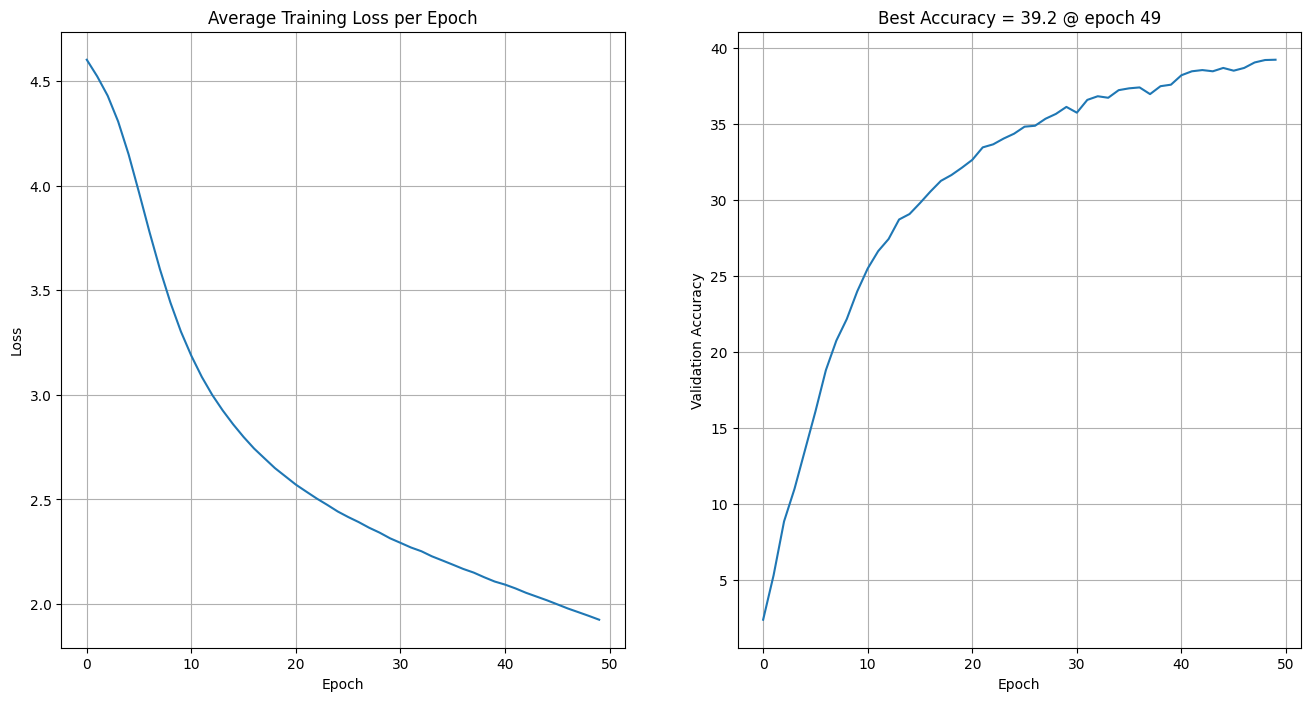

In [57]:
plot_losses_and_accuracies(SkipCNNlosses, SkipCNNaccuracies)

In [58]:
print(f'Accuracy on test set: {evaluate_model(model4, dl_test, opts)}')

Accuracy on test set: 39.79


### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.